<a href="https://colab.research.google.com/github/mdominguezd/DomainAdaptationCashewCropMapping_MGIThesis/blob/main/04_Cashew%20crop%20models/04_01_TrainUNet_No_DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using U-Net model to predict cashew crop extent remote sensing images

## 1) Import data and create dataset

In [1]:
!wget -O Tanzania.zip https://www.dropbox.com/scl/fi/98x2giz4flkiv9nigckkc/PlanetTanzania_16_17.zip?rlkey=gfwrv22x8zedqiusp3st8x6ex&dl=0 #2016-2017
# https://www.dropbox.com/scl/fi/hrvixl2a6amc7y8trza2d/PlanetTanzania.zip?rlkey=khxf3vp2cmm3rue7fqwi9rmxp&dl=0 # 2015-2018
!wget -O IvoryCoast.zip https://www.dropbox.com/scl/fi/xau507exs6sryyrejrrmw/PlanetIvoryCoast_16_17.zip?rlkey=akeun68qdtgfpapt7muxjmua9&dl=0 #2016-2017
# https://www.dropbox.com/scl/fi/lymeixhclxng0gowe9sp7/PlanetIvoryCoast.zip?rlkey=4zuq1y9bed85ruk3lmzkpqwgn&dl=0 # 2015-2018

--2023-11-28 09:00:04--  https://www.dropbox.com/scl/fi/98x2giz4flkiv9nigckkc/PlanetTanzania_16_17.zip?rlkey=gfwrv22x8zedqiusp3st8x6ex
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc598c608a0862d547bac9ed6667.dl.dropboxusercontent.com/cd/0/inline/CIbOQU3O2vaCyLS3rSDBIaZEeAFZ7jiqPMn_un1bXgKlIJw7KewdAPXVmnV5fy12-cN9KGpuaYGE0vD1MhOVZycVgDMiFN5a7rvZXJdHq0tzl3fNS81Dv1DvTFrWeIPwWbXc26KtxJzqWd857SZwLNRa/file# [following]
--2023-11-28 09:00:04--  https://uc598c608a0862d547bac9ed6667.dl.dropboxusercontent.com/cd/0/inline/CIbOQU3O2vaCyLS3rSDBIaZEeAFZ7jiqPMn_un1bXgKlIJw7KewdAPXVmnV5fy12-cN9KGpuaYGE0vD1MhOVZycVgDMiFN5a7rvZXJdHq0tzl3fNS81Dv1DvTFrWeIPwWbXc26KtxJzqWd857SZwLNRa/file
Resolving uc598c608a0862d547bac9ed6667.dl.dropboxusercontent.com (uc598c608a0862d547bac9ed6667.dl.dropboxusercontent.com)... 162.125

Import necessary libraries

In [19]:
!pip install torchmetrics -q
!pip install d2l==0.14.2 -q
!pip install focal_loss_torch -q

import os
import numpy as np
import geopandas as gpd
import pandas as pd
from zipfile import ZipFile
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as T
from torch.utils.data import random_split
from skimage import io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import shutil
from torch.autograd import Function
from torchmetrics import F1Score
from torchmetrics.classification import BinaryF1Score
from d2l import torch as d2l
from collections import deque
from statistics import mean
import seaborn as sns
from torch.autograd import Variable
# from focal_loss_pytorch.focal_loss_pytorch.focal_loss import BinaryFocalLoss

### Unzip and remove zipped files

In [3]:
with ZipFile("Tanzania.zip", 'r') as zipped:
    zipped.extractall(path="./")
with ZipFile("IvoryCoast.zip", 'r') as zipped:
    zipped.extractall(path="./")

os.remove('Tanzania.zip')
os.remove('IvoryCoast.zip')

## 2) Create DataSet Classes

### 2.1) Set Image Augmentation transforms.

In [4]:
# To ensure reproducible results.
seed = 8
np.random.seed(seed)

def brightness(i, increase = 0.5, prob = 0.5):
    if i.unique().shape[0] != 2: # Hard code
        p = np.random.random(1)
        if p < prob:
            p_inc = np.random.random(1)
            i = i*(1 + increase*p_inc)
            i[i>1] = 1.0
        else:
            p_dec = np.random.random(1)
            i = i*((1 - increase*p_dec))

    return i.float()


transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    # T.RandomResizedCrop((256,256), scale = (0.8,1)),
    # T.Lambda(brightness)
    ])

### 2.2.) Create Source and Target Class

In [5]:
# These values were calculated using the histograms on notebook 01_02_DataDistributionShift.ipynb
means_CIV = [338.995536,	677.268924,	630.248048,	2874.836857]
oneperc_CIV = [217.0,	528.0,	389.0,	2162.0]
ninenine_CIV = [542.0,	896.0,	984.0,	3877.0]
std_CIV = [67.369635,	79.766812,	131.564375,	365.127796]

means_TNZ = [299.61809,	584.028463,	545.825534,	3020.286079]
oneperc_TNZ = [171.00,	442.0,	302.71,	2236.00]
ninenine_TNZ = [496.29,	805.0,	846.00,	3775.29]
std_TNZ = [63.56492,	72.122137,	103.400951,	295.013028]

class Img_Dataset(Dataset):
    def __init__(self, img_folder, transform = None, split = 'Train', norm = 'StandardScaler', VI = True):
        self.img_folder = img_folder
        self.transform = transform
        self.split = split
        self.norm = norm
        self.VI = VI

    def __len__(self):
        return sum([self.split in i for i in os.listdir(self.img_folder)])//2

    def plot_imgs(self, idx, VIs = False):

        im, g = self.__getitem__(idx)

        if VIs:
            fig, ax = plt.subplots(2,2,figsize = (12,12))

            ax[0,0].imshow(im[[2,1,0],:,:].permute(1,2,0))
            ax[0,0].set_title('Planet image')
            ax[0,1].imshow(g[0,:,:])
            ax[0,1].set_title('Cashew crops GT')

            VIs = im[4:6]

            g1=ax[1,0].imshow(VIs[0], cmap = plt.cm.get_cmap('RdYlGn', 5), vmin = 0, vmax = 1)
            ax[1,0].set_title('NDVI')
            fig.colorbar(g1)
            g2=ax[1,1].imshow(VIs[1], cmap = plt.cm.get_cmap('Blues_r', 5), vmin = 0, vmax = 1)
            ax[1,1].set_title('NDWI')
            fig.colorbar(g2)

        else:
            fig, ax = plt.subplots(1,2,figsize = (12,6))

            ax[0].imshow(im[[2,1,0],:,:].permute(1,2,0))
            ax[0].set_title('Planet image')
            ax[1].imshow(g[0,:,:])
            ax[1].set_title('Cashew crops GT')


    def __getitem__(self, idx):
        #__getitem__ asks for the sample number idx.

        conversion = T.ToTensor()

        img = io.imread(fname = self.img_folder + '/Cropped' + self.img_folder + self.split + 'StudyArea_{:05d}'.format(idx) + '.tif').astype(np.float32)

        if self.VI:
            # Should I normalize this values between 0 and 1?
            if self.norm == 'Linear_1_99':
                ndvi = ((img[:,:,3] - img[:,:,2])/(img[:,:,3] + img[:,:,2]) - 0.37)/(0.86 - (0.37))
                ndwi = ((img[:,:,1] - img[:,:,3])/(img[:,:,3] + img[:,:,1]) - (-0.79))/((-0.41) - (-0.79))
            else:
                ndvi = (img[:,:,3] - img[:,:,2])/(img[:,:,3] + img[:,:,2])
                ndwi = (img[:,:,1] - img[:,:,3])/(img[:,:,3] + img[:,:,1])

        if self.norm == 'StandardScaler':
            for i in range(img.shape[-1]):
                if 'Tanz' in self.img_folder:
                    img[:,:,i] = (img[:,:,i] - means_TNZ[i])/(std_TNZ[i])
                elif 'Ivor' in self.img_folder:
                    img[:,:,i] = (img[:,:,i] - means_CIV[i])/(std_CIV[i])

        elif self.norm == 'Linear_1_99':
            for i in range(img.shape[-1]):
                if 'Tanz' in self.img_folder:
                    img[:,:,i] = (img[:,:,i] - oneperc_TNZ[i])/(ninenine_TNZ[i] - oneperc_TNZ[i])
                elif 'Ivor' in self.img_folder:
                    img[:,:,i] = (img[:,:,i] - oneperc_CIV[i])/(ninenine_CIV[i] - oneperc_CIV[i])

        if self.VI:
            ndvi = np.expand_dims(ndvi, axis = 2)
            ndwi = np.expand_dims(ndwi, axis = 2)
            img = np.concatenate((img, ndvi, ndwi), axis = 2)

        img = conversion(img).float()

        img = torchvision.tv_tensors.Image(img)

        GT = io.imread(fname = self.img_folder + '/Cropped' + self.img_folder + self.split + 'GT_{:05d}'.format(idx) + '.tif').astype(np.float32)

        GT = torch.flip(conversion(GT), dims = (1,))

        GT = torchvision.tv_tensors.Image(GT)

        if self.transform != None:
            GT, img = self.transform(GT, img)

        return img, GT

### 2.3) Check Dataset class

In [6]:
DS = Img_Dataset('IvoryCoast', transform, norm = 'Linear_1_99')
# DS = Tanzania_Dataset('Tanzania', transform)

DS.__len__()

7778

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
<ipython-input-5-eb91ab6d3b1b>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  g1=ax[1,0].imshow(VIs[0], cmap = plt.cm.get_cmap('RdYlGn', 5), vmin = 0, vmax = 1)
<ipython-input-5-eb91ab6d3b1b>:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  g2=ax[1,1].imshow(VIs[1], cmap = plt.cm.get_cmap('Blues_r', 5), vmin = 0, vmax = 1)


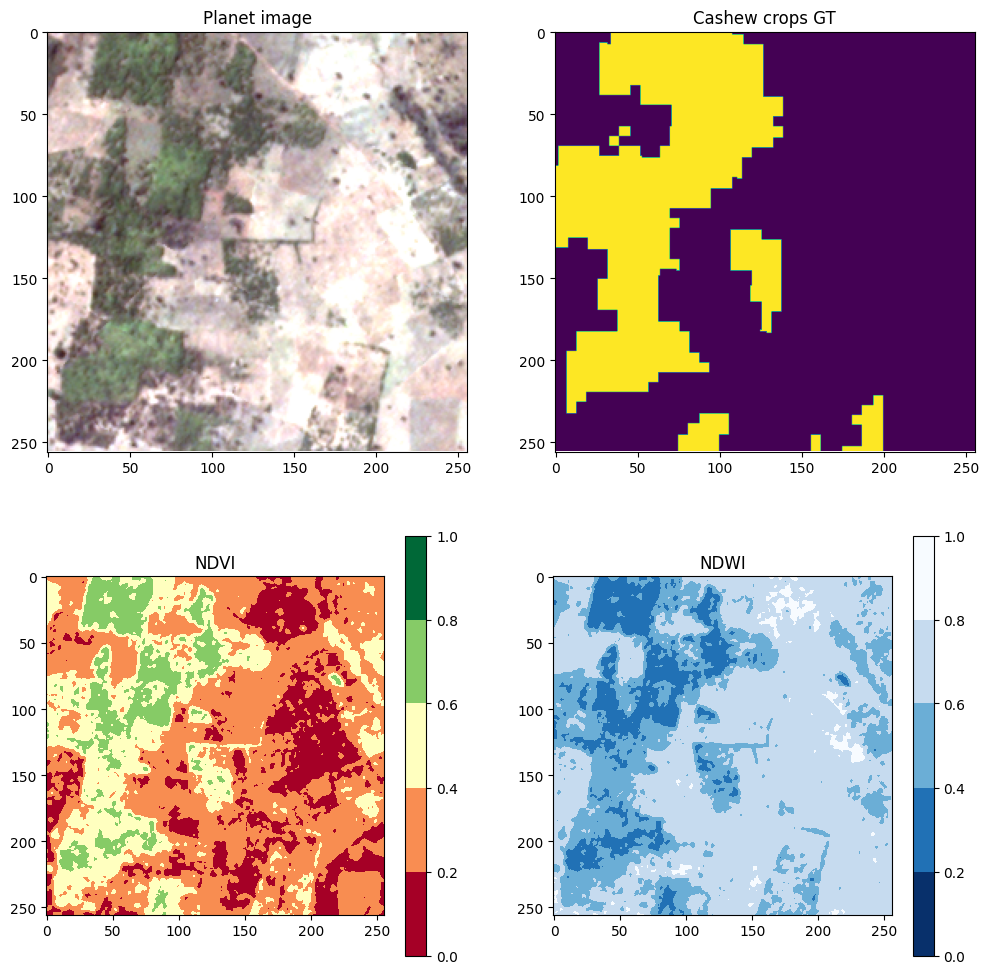

In [7]:
DS.plot_imgs(1530, True)

## 3) Build the model

### 3.1) Building blocks of a UNet

Taken from: https://github.com/milesial/Pytorch-UNet/tree/master

In [8]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # print(diffY, diffX)

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.conv(x)
        return x

### Possible attention block to be added to unet
class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi

### 3.2) Feature extractor and classifer classes

In [9]:
class FE(nn.Module):
    """
      Class for the creation of the feature extractor.
    """
    def __init__(self, n_channels, starter, up_layer, bilinear = True):
        super(FE, self).__init__()

        self.n_channels = n_channels
        self.bilinear = bilinear
        self.starter = starter
        self.up_layer = up_layer

        # Layers related to segmentation task
        self.inc = (DoubleConv(self.n_channels, self.starter))
        self.down1 = (Down(self.starter, self.starter*(2**1)))
        self.down2 = (Down(self.starter*(2**1), self.starter*(2**2)))
        self.down3 = (Down(self.starter*(2**2), self.starter*(2**3)))
        factor = 2 if bilinear else 1
        self.down4 = (Down(self.starter*(2**3), self.starter*(2**4) // factor))
        if self.up_layer >= 1:
            self.up1 = (Up(self.starter*(2**4), self.starter*(2**3) // factor, bilinear))
        if self.up_layer >= 2:
            self.up2 = (Up(self.starter*(2**3), self.starter*(2**2) // factor, bilinear))
        if self.up_layer >= 3:
            self.up3 = (Up(self.starter*(2**2), self.starter*(2**1) // factor, bilinear))
        if self.up_layer >= 4:
            self.up4 = (Up(self.starter*(2**1), self.starter, bilinear))

    def DownSteps(self, x):

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        return x1, x2, x3, x4, x5

    def forward(self, x):

        # Downsample steps
        x1, x2, x3, x4, x5 = self.DownSteps(x)

        # Upsample steps
        if self.up_layer == 0:
            x = x5
        if self.up_layer >= 1:
            x = self.up1(x5, x4)
        if self.up_layer >= 2:
            x = self.up2(x, x3)
        if self.up_layer >= 3:
            x = self.up3(x, x2)
        if self.up_layer >= 4:
            x = self.up4(x, x1)

        return x

class C(nn.Module):
    def __init__(self, n_channels, starter, up_layer, bilinear = True, n_classes = 2):
        super(C, self).__init__()

        self.n_channels = n_channels
        self.bilinear = bilinear
        self.starter = starter
        self.up_layer = up_layer
        self.n_classes = n_classes

        factor = 2 if bilinear else 1

        if self.up_layer == 0:
            self.up1 = (Up(self.starter*(2**4), self.starter*(2**3) // factor, bilinear))
            self.up2 = (Up(self.starter*(2**3), self.starter*(2**2) // factor, bilinear))
            self.up3 = (Up(self.starter*(2**2), self.starter*(2**1) // factor, bilinear))
            self.up4 = (Up(self.starter*(2**1), self.starter, bilinear))
            self.outc = (OutConv(self.starter, n_classes))
        elif self.up_layer == 1:
            self.up2 = (Up(self.starter*(2**3), self.starter*(2**2) // factor, bilinear))
            self.up3 = (Up(self.starter*(2**2), self.starter*(2**1) // factor, bilinear))
            self.up4 = (Up(self.starter*(2**1), self.starter, bilinear))
            self.outc = (OutConv(self.starter, n_classes))
        elif self.up_layer == 2:
            self.up3 = (Up(self.starter*(2**2), self.starter*(2**1) // factor, bilinear))
            self.up4 = (Up(self.starter*(2**1), self.starter, bilinear))
            self.outc = (OutConv(self.starter, n_classes))
        elif self.up_layer == 3:
            self.up4 = (Up(self.starter*(2**1), self.starter, bilinear))
            self.outc = (OutConv(self.starter, n_classes))
        elif self.up_layer == 4:
            self.outc = (OutConv(self.starter, n_classes))


    def forward(self, x, dw):
        # Downsample steps
        x1, x2, x3, x4, x5 = dw

        # Upsampling steps
        if self.up_layer == 0:
            x = self.up1(x5, x4)
            x = self.up2(x, x3)
            x = self.up3(x, x2)
            x = self.up4(x, x1)
            logits = self.outc(x)
        elif self.up_layer == 1:
            x = self.up2(x, x3)
            x = self.up3(x, x2)
            x = self.up4(x, x1)
            logits = self.outc(x)
        elif self.up_layer == 2:
            x = self.up3(x, x2)
            x = self.up4(x, x1)
            logits = self.outc(x)
        elif self.up_layer == 3:
            x = self.up4(x, x1)
            logits = self.outc(x)
        elif self.up_layer == 4:
            logits = self.outc(x)

        return logits

### 3.3 Build the network class

Taken from: https://github.com/milesial/Pytorch-UNet/tree/master

In [10]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True, starter = 8, up_layer = 3):

        super(UNet, self).__init__()

        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.starter = starter
        self.up_layer = up_layer

        self.FE = (FE(self.n_channels, self.starter, self.up_layer, self.bilinear))
        self.C = (C(self.n_channels, self.starter, self.up_layer, self.bilinear, self.n_classes))

        self.apply(self._init_weights)

    def forward(self, x):

        features = self.FE(x) # Feature extractor
        down_st = self.FE.DownSteps(x) # Get channels that will be concatenated from downward steps

        logits = self.C(features, down_st) # Classifier

        return logits


    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

### 3.4) Create Focal Loss class
Taken from: https://github.com/amirhosseinh77/UNet-AerialSegmentation/tree/main

In [11]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=-1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

## 4) Training loop definition

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
def evaluate(net, validate_loader, loss_function):
  #You need to set the network to eval mode when using batch normalization (to
  #be consistent across evaluation samples, we use mean and stddev computed
  #during training when doing inference, as opposed to ones computed on the
  #batch) or dropout (you want to use all the parameters during inference).
  net.eval()  # Set the model to evaluation mode
  device = next(iter(net.parameters())).device
  metric = d2l.Accumulator(4)
  #This line reduces the memory by not tracking the gradients. Also to be used
  #during inference.
  with torch.no_grad():
    for i, (inputs, GTs) in enumerate(validate_loader):
      #Send inputs and GTs them to the computation device (i.e. GPU). The GTs tensor
      #has to be converted to nn.LongTensor type (a type of integer) and turned into
      #a 3D tensor by removing dimension 1 with the squeeze() function.
      inputs = inputs.to(device)
      GTs = GTs.type(torch.long).squeeze().to(device)
      pred = net(inputs)

      loss = loss_function(pred, GTs)

      f1 = BinaryF1Score().to(device)
      overall_accuracy = f1(pred.max(1)[1], GTs)
      metric.add(loss, GTs.shape[0], overall_accuracy, 1)

  return metric



def training_loop(learning_rate, starter_channels, momentum, epochs, bilinear = True, animate = False, n_channels = 4, seed = 8):
  np.random.seed(seed)

  number_epochs = epochs

  if animate:
    animator = d2l.Animator(xlabel='epoch', xlim=[0, number_epochs], ylim=[0, 1],
                        legend=['train CE loss', 'train F1-Score', 'val CE loss', 'val F1-Score'],
                        fmts=('-', 'm--', 'g-.', 'r:'),
                        figsize=(7, 5))

  torch.manual_seed(seed)
  # torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  network = UNet(n_channels=n_channels, n_classes=2, bilinear=bilinear, starter = starter_channels, up_layer = 4)
  network.to(device)
  optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum = momentum)

  #Training metrics are computed as a running average of the last x samples
  loss_train = deque(maxlen=len(train_loader))
  accuracy_train = deque(maxlen=len(train_loader))

  for epoch in range(number_epochs):

    #Validation phase:
    metric_val = evaluate(network, val_loader, loss_function)
    if animate:
      animator.add(epoch,(None, None, metric_val[0]/metric_val[1], metric_val[2]/metric_val[3]))

    #Training phase:
    network.train() #indicate to the network that we enter training mode

    for i, (inputs, GTs) in enumerate(train_loader):

      inputs = inputs.to(device)
      GTs = GTs.type(torch.long).squeeze().to(device)
      #We set the gradients of the model to 0.
      optimizer.zero_grad()
      pred = network(inputs)

      loss = loss_function(pred, GTs)

      f1 = BinaryF1Score().to(device)
      overall_accuracy = f1(pred.max(1)[1], GTs)
      #We accumulate the gradients...
      loss.backward()
      #...and we update the parameters according to the gradients.
      optimizer.step()
      loss_train.append(loss.item()/GTs.shape[0])
      accuracy_train.append(overall_accuracy.item())

      if animate:
        animator.add(epoch+i/len(train_loader),
                          (mean(loss_train), mean(accuracy_train), None, None))

    if epoch == 0:
        best_model = metric_val[2]/metric_val[3]
        torch.save(network, 'drive/MyDrive/BestModel.pt')
    else:
        if best_model < metric_val[2]/metric_val[3]:
            torch.save(network, 'drive/MyDrive/BestModel.pt')

    if (epoch//4 == epoch/4):
        #After each training epoch, reduce the learning rate by a factor of 0.5
        optimizer.param_groups[0]['lr'] *= 0.5

  metric_val = evaluate(network, val_loader, loss_function)

  if animate:
    animator.add(epoch+1,(None, None, metric_val[0]/metric_val[1], metric_val[2]/metric_val[3]))

  return(best_model, metric_val[0]/metric_val[1], network)

## 5) Hyperparameter tuning

In [ ]:
CIV_train_DS = Img_Dataset('IvoryCoast', transform)
CIV_val_DS = Img_Dataset('IvoryCoast', split = 'Validation')
CIV_test_DS = Img_Dataset('IvoryCoast', split = 'Test')

TNZ_train_DS = Img_Dataset('Tanzania', transform)
TNZ_val_DS = Img_Dataset('Tanzania', split = 'Validation')
TNZ_test_DS = Img_Dataset('Tanzania', split = 'Test')

In [ ]:
batch_size = 16

learning_rate = [0.1, 0.2, 0.4]
starter_channels = [8, 16, 32]
momentum =	[0, 0.8]
bilinear =  [True]

loss_function = torch.nn.CrossEntropyLoss()

domain = 'source'

In [ ]:
CIV_train_DS_sub, l_ = random_split(CIV_train_DS, [0.1, 0.9], generator=torch.Generator().manual_seed(8))
CIV_val_DS_sub, l_ = random_split(CIV_val_DS, [0.75, 0.25], generator=torch.Generator().manual_seed(8))

TNZ_train_DS_sub, l_ = random_split(TNZ_train_DS, [0.1, 0.9], generator=torch.Generator().manual_seed(8))
TNZ_val_DS_sub, l_ = random_split(TNZ_val_DS, [0.75, 0.25], generator=torch.Generator().manual_seed(8))

if domain == 'source':
  # Create data loaders
  train_loader = torch.utils.data.DataLoader(dataset=CIV_train_DS_sub, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(dataset=CIV_val_DS_sub, batch_size=batch_size, shuffle=False)
else:
  # Create data loaders
  train_loader = torch.utils.data.DataLoader(dataset=TNZ_train_DS_sub, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(dataset=TNZ_val_DS_sub, batch_size=batch_size, shuffle=False)

In [ ]:
rows = []
iterations = 3

for l in learning_rate:
  for st in starter_channels:
    for mu in momentum:
      for bi in bilinear:
        v_ = []
        l_ = []
        for i in range(iterations):
          v, loss, n = training_loop(l, st, mu, 10, animate=False, n_channels = 6, seed = i,  bilinear = bi)
          v_.append(v)
          l_.append(loss)

        loss = np.mean(l_)
        v = np.mean(v_)

        print('Done with:\n    LR:' + str(l) + '    starter channels:' + str(st) +
              '    momentum:' + str(mu) + '    bilinear ' + str(bi)  + '\n    f1:' + str(v))

        rows.append([l, st, mu, bi, loss, v])

        df = pd.DataFrame(rows)
        df.columns = ['LR', 'StartCh', 'Momentum', 'Bilinear', 'ValLoss', 'ValF1Score']
        df.to_csv('drive/MyDrive/TempHyperParamTuning_TNZ.csv')


df = pd.DataFrame(rows)
df.columns = ['LR', 'StartCh', 'Momentum', 'Bilinear', 'ValLoss', 'ValF1Score']

df.sort_values('ValF1Score', ascending = False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Done with:
    LR:0.1    starter channels:8    momentum:0    bilinear True
    f1:0.4731774240732192


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Done with:
    LR:0.1    starter channels:8    momentum:0.8    bilinear True
    f1:0.4750635653734207


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Done with:
    LR:0.1    starter channels:16    momentum:0    bilinear True
    f1:0.488459038734436


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Done with:
    LR:0.1    starter channels:16    momentum:0.8    bilinear True
    f1:0.4897160271803538


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Done with:
    LR:0.1    starter channels:32    momentum:0    bilinear True
    f1:0.5380327254533768


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Done with:
    LR:0.1    starter channels:32    momentum:0.8    bilinear True
    f1:0.4899652083714803


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Done with:
    LR:0.2    starter channels:8    momentum:0    bilinear True
    f1:0.4983661770820618


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Done with:
    LR:0.2    starter channels:8    momentum:0.8    bilinear True
    f1:0.47040399213631945


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Done with:
    LR:0.2    starter channels:16    momentum:0    bilinear True
    f1:0.47628725071748096


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Done with:
    LR:0.2    starter channels:16    momentum:0.8    bilinear True
    f1:0.4592450976371765


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Done with:
    LR:0.2    starter channels:32    momentum:0    bilinear True
    f1:0.5148241380850475


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Done with:
    LR:0.2    starter channels:32    momentum:0.8    bilinear True
    f1:0.4776772300402324


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Done with:
    LR:0.4    starter channels:8    momentum:0    bilinear True
    f1:0.4898843318223953


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Done with:
    LR:0.4    starter channels:8    momentum:0.8    bilinear True
    f1:0.47931252221266435


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Done with:
    LR:0.4    starter channels:16    momentum:0    bilinear True
    f1:0.4800302217404047


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Done with:
    LR:0.4    starter channels:16    momentum:0.8    bilinear True
    f1:0.4583193272352218


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Done with:
    LR:0.4    starter channels:32    momentum:0    bilinear True
    f1:0.4853441129128138


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Done with:
    LR:0.4    starter channels:32    momentum:0.8    bilinear True
    f1:0.4898741940657298


,LR,StartCh,Momentum,Bilinear,ValLoss,ValF1Score
4,0.1,32,0.0,True,0.036801,0.538033
10,0.2,32,0.0,True,0.034947,0.514824
6,0.2,8,0.0,True,0.035808,0.498366
5,0.1,32,0.8,True,0.034546,0.489965
12,0.4,8,0.0,True,0.039889,0.489884
17,0.4,32,0.8,True,0.034456,0.489874
3,0.1,16,0.8,True,0.034445,0.489716
2,0.1,16,0.0,True,0.034737,0.488459
16,0.4,32,0.0,True,0.035889,0.485344
14,0.4,16,0.0,True,0.034039,0.480030


In [ ]:
df = pd.DataFrame(rows)
df.columns = ['LR', 'StartCh', 'Momentum', 'Bilinear', 'ValLoss', 'ValF1Score']

df.sort_values('ValF1Score', ascending = False)

,LR,StartCh,Momentum,Bilinear,ValLoss,ValF1Score
4,0.1,32,0.0,True,0.036801,0.538033
10,0.2,32,0.0,True,0.034947,0.514824
6,0.2,8,0.0,True,0.035808,0.498366
5,0.1,32,0.8,True,0.034546,0.489965
12,0.4,8,0.0,True,0.039889,0.489884
17,0.4,32,0.8,True,0.034456,0.489874
3,0.1,16,0.8,True,0.034445,0.489716
2,0.1,16,0.0,True,0.034737,0.488459
16,0.4,32,0.0,True,0.035889,0.485344
14,0.4,16,0.0,True,0.034039,0.480030


In [ ]:
 df.sort_values('ValLoss', ascending = True)

,LR,StartCh,Momentum,Bilinear,ValLoss,ValF1Score
8,0.2,16,0.0,True,0.033427,0.476287
14,0.4,16,0.0,True,0.034039,0.480030
15,0.4,16,0.8,True,0.034072,0.458319
11,0.2,32,0.8,True,0.034103,0.477677
3,0.1,16,0.8,True,0.034445,0.489716
17,0.4,32,0.8,True,0.034456,0.489874
9,0.2,16,0.8,True,0.034486,0.459245
5,0.1,32,0.8,True,0.034546,0.489965
2,0.1,16,0.0,True,0.034737,0.488459
10,0.2,32,0.0,True,0.034947,0.514824


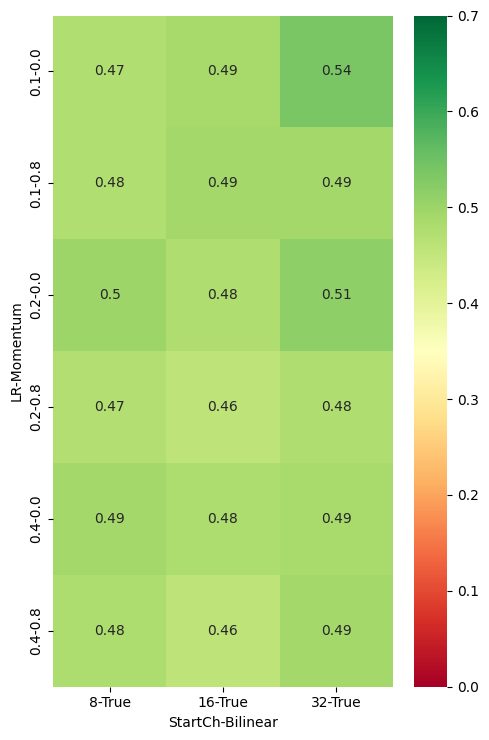

In [ ]:
try:
    df
except:
    df = pd.read_csv('drive/MyDrive/TempHyperParamTuning_TNZ.csv')

piv_tab_lr = pd.pivot_table(df, values = 'ValF1Score', index = ['LR', 'Momentum'], columns = ['StartCh', 'Bilinear'], aggfunc = 'mean')
piv_tab_mu = pd.pivot_table(df, values = 'ValF1Score', index = ['Momentum'], columns = ['StartCh'], aggfunc = 'mean')

fig, ax = plt.subplots(1,1,figsize = (5,7.5))

sns.heatmap(piv_tab_lr, cmap = 'RdYlGn', vmin = 0, vmax = 0.7, annot = True, ax = ax)

plt.tight_layout()
fig.savefig('Hyperparameter_Tuning10percData_CIV.png', dpi = 200)

## 6) Final training

### 6.1) Set Hyper-parameters

In [15]:
#Set params
batch_size = 16
epochs = 20

learning_rate = 0.1
starter_channels = 32
momentum = 0.0
bi = True

# weights = torch.FloatTensor([2, 0.7])
loss_function = FocalLoss(gamma =  0.7)
# BinaryFocalLoss(gamma=5)
# torch.nn.CrossEntropyLoss()

# DOMAIN
domain = 'source'

# Normalization and VI
normalization = 'Linear_1_99'
Use_VI = False
ch = 4

if Use_VI:
  ch = 6

### 6.2) Dataset for training

In [16]:
# To ensure reproducible results.
seed = 8
np.random.seed(seed)

def brightness(i, increase = 0.1, prob = 0.5):
    if i.unique().shape[0] != 2: # Hard code

        p = np.random.random(1)

        if p < prob:
            p_inc = np.random.random(1)
            i[:4] = i[:4]*(1 + increase*p_inc)
        else:
            p_dec = np.random.random(1)
            i[:4] = i[:4]*((1 - increase*p_dec))

    return i.float()


transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.Lambda(brightness)
    ])

In [17]:
CIV_train_DS = Img_Dataset('IvoryCoast', transform, norm = normalization, VI = Use_VI)
CIV_val_DS = Img_Dataset('IvoryCoast', split = 'Validation', norm = normalization, VI = Use_VI)
CIV_test_DS = Img_Dataset('IvoryCoast', split = 'Test', norm = normalization, VI = Use_VI)

TNZ_train_DS = Img_Dataset('Tanzania', transform, norm = normalization, VI = Use_VI)
TNZ_val_DS = Img_Dataset('Tanzania', split = 'Validation', norm = normalization, VI = Use_VI)
TNZ_test_DS = Img_Dataset('Tanzania', split = 'Test', norm = normalization, VI = Use_VI)

if domain == 'source':
  # Create data loaders
  train_loader = torch.utils.data.DataLoader(dataset=CIV_train_DS, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(dataset=CIV_val_DS, batch_size=batch_size, shuffle=False)
else:
  # Create data loaders
  train_loader = torch.utils.data.DataLoader(dataset=TNZ_train_DS, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(dataset=TNZ_val_DS, batch_size=batch_size, shuffle=False)

iterable_train_loader = enumerate(train_loader)

### 6.3) Training loop

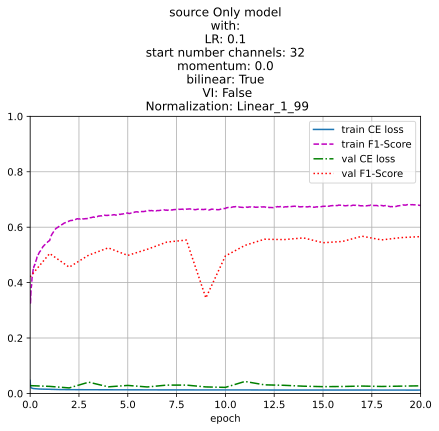

In [20]:
v, t, network = training_loop(learning_rate, starter_channels, momentum, epochs, bi, True, n_channels=ch, seed=8)

fig = plt.gcf()

ax = plt.gca()

ax.set_title(domain + ' Only model\nwith:\nLR: '+ str(learning_rate) +
             '\nstart number channels: ' + str(starter_channels) +
             '\nmomentum: ' + str(momentum) +
             '\nbilinear: ' + str(bi) +
             '\n VI: ' + str(Use_VI) +
             '\n Normalization: ' + normalization
             )

fig.savefig('drive/MyDrive/' + domain + 'OnlyModel_TrainingLoop_.png', bbox_inches = 'tight')

In [ ]:
torch.save(network, 'drive/MyDrive/U_Net_' + domain + 'Only_' +
           str(Use_VI) + 'VI_' + normalization + '_' +
           str(learning_rate) + 'LR_' + str(starter_channels) +
           'st_' + str(momentum) + 'mu_' +str(epochs) + 'eps_.pt')

## 8) Assess pre trained model

In [ ]:
def PreTrained_training_loop(network, learning_rate, momentum, epochs, animate = False, seed = 8):
  np.random.seed(seed)

  number_epochs = epochs

  if animate:
    animator = d2l.Animator(xlabel='epoch', xlim=[0, number_epochs], ylim=[0, 1],
                        legend=['train CE loss', 'train F1-Score', 'val CE loss', 'val F1-Score'],
                        fmts=('-', 'm--', 'g-.', 'r:'),
                        figsize=(7, 5))

  network.to(device)
  optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum = momentum)

  #Training metrics are computed as a running average of the last x samples
  loss_train = deque(maxlen=len(train_loader))
  accuracy_train = deque(maxlen=len(train_loader))

  for epoch in range(number_epochs):
    print(epoch)
    #Validation phase:
    metric_val = evaluate(network, val_loader, loss_function)
    if animate:
      animator.add(epoch,(None, None, metric_val[0]/metric_val[1], metric_val[2]/metric_val[3]))

    #Training phase:
    network.train() #indicate to the network that we enter training mode

    for i, (inputs, GTs) in enumerate(train_loader):

      inputs = inputs.to(device)
      GTs = GTs.type(torch.long).squeeze().to(device)
      #We set the gradients of the model to 0.
      optimizer.zero_grad()
      pred = network(inputs)
      loss = loss_function(pred, GTs)
      f1 = BinaryF1Score().to(device)
      overall_accuracy = f1(pred.max(1)[1], GTs)
      #We accumulate the gradients...
      loss.backward()
      #...and we update the parameters according to the gradients.
      optimizer.step()
      loss_train.append(loss.item()/GTs.shape[0])
      accuracy_train.append(overall_accuracy.item())

      if animate:
        animator.add(epoch+i/len(train_loader),
                          (mean(loss_train), mean(accuracy_train), None, None))

    if epoch == 0:
        best_model = metric_val[2]/metric_val[3]
        torch.save(network, 'drive/MyDrive/BestPreTrainedModel.pt')
    else:
        if best_model < metric_val[2]/metric_val[3]:
            torch.save(network, 'drive/MyDrive/BestPreTrainedModel.pt')

    if (epoch//4 == epoch/4):
        #After each training epoch, reduce the learning rate by a factor of 0.1
        optimizer.param_groups[0]['lr'] *= 0.5

  metric_val = evaluate(network, val_loader, loss_function)

  if animate:
    animator.add(epoch+1,(None, None, metric_val[0]/metric_val[1], metric_val[2]/metric_val[3]))

  return(best_model, metric_val[0]/metric_val[1], network)

In [ ]:
#Set params
batch_size = 16
epochs = 20

learning_rate = 0.4
starter_channels = 32
momentum = 0.0
bi = True

loss_function = torch.nn.CrossEntropyLoss()

# DOMAIN
domain = 'target'

# Normalization and VI
normalization = 'Linear_1_99'
Use_VI = False
ch = 4

if Use_VI:
  ch = 6

In [ ]:
CIV_train_DS = Img_Dataset('IvoryCoast', transform, norm = normalization, VI = Use_VI)
CIV_val_DS = Img_Dataset('IvoryCoast', split = 'Validation', norm = normalization, VI = Use_VI)
CIV_test_DS = Img_Dataset('IvoryCoast', split = 'Test', norm = normalization, VI = Use_VI)

TNZ_train_DS = Img_Dataset('Tanzania', transform, norm = normalization, VI = Use_VI)
TNZ_val_DS = Img_Dataset('Tanzania', split = 'Validation', norm = normalization, VI = Use_VI)
TNZ_test_DS = Img_Dataset('Tanzania', split = 'Test', norm = normalization, VI = Use_VI)

if domain == 'source':
  # Create data loaders
  train_loader = torch.utils.data.DataLoader(dataset=CIV_train_DS, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(dataset=CIV_val_DS, batch_size=batch_size, shuffle=False)
else:
  # Create data loaders
  train_loader = torch.utils.data.DataLoader(dataset=TNZ_train_DS, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(dataset=TNZ_val_DS, batch_size=batch_size, shuffle=False)

iterable_train_loader = enumerate(train_loader)

In [ ]:
!pip install segmentation_models_pytorch -q

In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="mit_b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=4,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

model.train()

In [ ]:
PreTrained_training_loop(model, learning_rate, momentum, epochs, animate = True)

In [ ]:
model = torch.load('drive/MyDrive/BestModel.pt')
model.eval()

CIV_te = Img_Dataset('IvoryCoast', split = 'Test', VI = Use_VI, norm = normalization)
TNZ_te = Img_Dataset('Tanzania', split = 'Test', VI = Use_VI, norm = normalization)

CIV_test_loader = torch.utils.data.DataLoader(dataset=CIV_te, batch_size=batch_size, shuffle=False)
TNZ_test_loader = torch.utils.data.DataLoader(dataset=TNZ_te, batch_size=batch_size, shuffle=False)

CIV_iterable_test_loader = enumerate(CIV_test_loader)
TNZ_iterable_test_loader = enumerate(TNZ_test_loader)

def PreTr_evaluate(net, validate_loader):
  #You need to set the network to eval mode when using batch normalization (to
  #be consistent across evaluation samples, we use mean and stddev computed
  #during training when doing inference, as opposed to ones computed on the
  #batch) or dropout (you want to use all the parameters during inference).
  net.eval()  # Set the model to evaluation mode
  device = next(iter(net.parameters())).device
  #This line reduces the memory by not tracking the gradients. Also to be used
  #during inference.
  f1_scores = []

  for i, (inputs, GTs) in enumerate(validate_loader):
      #Send inputs and GTs them to the computation device (i.e. GPU). The GTs tensor
      #has to be converted to nn.LongTensor type (a type of integer) and turned into
      #a 3D tensor by removing dimension 1 with the squeeze() function.
      inputs = inputs.to(device)
      GTs = GTs.type(torch.long).squeeze().to(device)
      pred = net(inputs)

      f1 = BinaryF1Score().to(device)
      f1_score = f1(pred.max(1)[1], GTs)
      f1_scores.append(f1_score.to('cpu').numpy())

  return np.mean(f1_scores)

print(PreTr_evaluate(model, CIV_test_loader), PreTr_evaluate(model, TNZ_test_loader))

0.0011053632 0.61994493


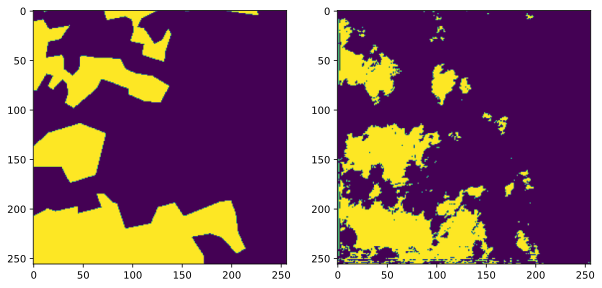

In [ ]:
im, gt = DS.__getitem__(700)
pred = network(im[None, :, :, :].to(device))
pred_ = pred[0,:,:,:].max(0)[1].cpu().numpy()

figs, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(gt[0])
ax[1].imshow(pred_)

In [ ]:
!pip install focal-loss-pytorch

In [ ]:
from torchvision.ops import sigmoid_focal_loss

In [ ]:
from focal_loss.focal_loss import FocalLoss

# Withoout class weights
criterion = FocalLoss(gamma=0.7)

In [ ]:
batch_size = 10
m = torch.nn.Sigmoid()
logits = torch.randn(batch_size, 256, 256)
target = torch.randint(0, 2, size=(batch_size,256, 256))
loss = criterion(m(logits).flatten(), target.flatten())

In [ ]:
m(logits).flatten().shape

torch.Size([655360])

In [ ]:
target.shape

torch.Size([10, 256, 256])